In [1]:
import gzip
import pandas
import pickle
import seaborn
import tqdm

from lib.models.aft20barzur import ptmdp
from lib.models.generic_v0.model import map_params

In [2]:
mdps = pandas.read_pickle("5-generated-mdps/fixed.pkl.gz")
mdps

,scenario,model,protocol,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,dag_size_limit,size,time_spent,rss,mdp
0,baseline,generic_1,bitcoin,False,False,True,True,False,5,10870,5.265134,0.251690,1215d126
1,baseline,generic_1,ethereum_3,False,False,True,True,False,5,11876,6.134111,0.264961,347d47e3
2,baseline,generic_1,byzantium_3,False,False,True,True,False,5,11876,6.450769,0.259777,34b2c2bf
3,baseline,generic_1,ghostdag_3,False,False,True,True,False,5,10573,6.447067,0.246181,5ae2d92b
4,baseline,generic_1,parallel_3,False,False,True,True,False,5,3637,1.929493,0.216213,3784d81e
5,w/o truncate,generic_1,bitcoin,False,False,False,True,False,5,12892,5.592142,0.278366,4b9c96f9
6,w/o truncate,generic_1,ethereum_3,False,False,False,True,False,5,13922,6.631893,0.285465,344c40b7
7,w/o truncate,generic_1,byzantium_3,False,False,False,True,False,5,13922,7.077445,0.285618,2638371e
8,w/o truncate,generic_1,ghostdag_3,False,False,False,True,False,5,12291,5.958618,0.268909,d7e36bfa
9,w/o truncate,generic_1,parallel_3,False,False,False,True,False,5,3637,1.837963,0.248631,10a26e96


In [3]:
networks = []
# for alpha in range(5, 51, 5):
for alpha in range(35, 41, 5):
    for gamma in [0.33, 0.66]:
        # for gamma in [0, 0.5, 1]:
        networks.append(dict(alpha=alpha / 100, gamma=gamma))
# pandas.DataFrame(networks)

In [4]:
horizon = 100
stop_delta = (
    0.001  # value iteration stops when no value estimate changes more than this value
)

with tqdm.tqdm(total=len(networks) * len(mdps)) as pbar:
    rows = []
    for network in networks:
        for i, row in mdps.iterrows():
            with gzip.open(f"5-generated-mdps/mdp-{row.mdp}.pkl.gz", "rb") as f:
                emdp = pickle.load(f)
            emdp = map_params(emdp, **network)
            emdp = ptmdp(emdp, horizon=horizon)
            vi = emdp.value_iteration(discount=1, stop_delta=stop_delta)
            policy = vi.pop("vi_policy")
            state_fut_reward = vi.pop("vi_value")
            state_fut_progress = vi.pop("vi_progress")

            episode_reward = 0
            episode_progress = 0
            for state, prb in emdp.start.items():
                episode_reward += prb * state_fut_reward[state]
                episode_progress += prb * state_fut_progress[state]

            res = dict(
                episode_reward=episode_reward,
                episode_progress=episode_progress,
                episode_reward_per_progress=episode_reward / episode_progress,
            )

            rows.append(row.to_dict() | network | vi | res)

            pbar.update(1)

df = pandas.DataFrame(rows)
df.to_pickle("5-value-iterations.pkl.gz")
df

  0%|                                                                 | 0/100 [00:00<?, ?it/s]

  1%|▌                                                      | 1/100 [00:40<1:06:56, 40.57s/it]

  2%|█                                                      | 2/100 [01:18<1:03:46, 39.04s/it]

  3%|█▋                                                     | 3/100 [01:58<1:03:39, 39.38s/it]

  4%|██▎                                                      | 4/100 [02:31<59:21, 37.10s/it]

/tmp/ipykernel_15661/2616413515.py:28: RuntimeWarning: invalid value encountered in scalar divide
  episode_reward_per_progress=episode_reward / episode_progress,
  5%|██▊                                                      | 5/100 [02:32<37:38, 23.77s/it]

  6%|███▍                                                     | 6/100 [02:32<25:03, 15.99s/it]

  7%|███▉                                                     | 7/100 [02:33<17:12, 11.10s/it]

  8%|████▌                                                    | 8/100 [02:35<12:07,  7.90s/it]

  9%|█████▏                                                   | 9/100 [02:35<08:38,  5.70s/it]

 10%|█████▌                                                  | 10/100 [02:36<05:57,  3.97s/it]

 11%|██████▏                                                 | 11/100 [02:36<04:29,  3.02s/it]

 12%|██████▋                                                 | 12/100 [02:37<03:28,  2.37s/it]

 13%|███████▎                                                | 13/100 [02:38<02:46,  1.91s/it]

 14%|███████▊                                                | 14/100 [02:39<02:14,  1.57s/it]

 16%|████████▉                                               | 16/100 [02:50<04:42,  3.36s/it]

 17%|█████████▌                                              | 17/100 [03:00<07:05,  5.13s/it]

 18%|██████████                                              | 18/100 [03:10<08:49,  6.45s/it]

 19%|██████████▋                                             | 19/100 [03:21<10:07,  7.49s/it]

 21%|███████████▊                                            | 21/100 [03:21<05:43,  4.35s/it]

 22%|████████████▎                                           | 22/100 [03:22<04:28,  3.44s/it]

 23%|████████████▉                                           | 23/100 [03:22<03:28,  2.70s/it]

 24%|█████████████▍                                          | 24/100 [03:23<02:40,  2.12s/it]

 26%|██████████████▌                                         | 26/100 [04:06<13:02, 10.57s/it]

 27%|███████████████                                         | 27/100 [04:46<21:16, 17.49s/it]

 28%|███████████████▋                                        | 28/100 [05:26<27:44, 23.12s/it]

 29%|████████████████▏                                       | 29/100 [06:00<30:44, 25.97s/it]

 30%|████████████████▊                                       | 30/100 [06:00<22:02, 18.89s/it]

 31%|█████████████████▎                                      | 31/100 [06:01<15:53, 13.83s/it]

 32%|█████████████████▉                                      | 32/100 [06:02<11:31, 10.16s/it]

 33%|██████████████████▍                                     | 33/100 [06:03<08:24,  7.53s/it]

 34%|███████████████████                                     | 34/100 [06:04<06:03,  5.51s/it]

 35%|███████████████████▌                                    | 35/100 [06:04<04:15,  3.93s/it]

 36%|████████████████████▏                                   | 36/100 [06:05<03:13,  3.02s/it]

 37%|████████████████████▋                                   | 37/100 [06:06<02:28,  2.36s/it]

 38%|█████████████████████▎                                  | 38/100 [06:06<01:57,  1.90s/it]

 39%|█████████████████████▊                                  | 39/100 [06:07<01:36,  1.57s/it]

 41%|██████████████████████▉                                 | 41/100 [06:19<03:29,  3.55s/it]

 42%|███████████████████████▌                                | 42/100 [06:29<05:04,  5.24s/it]

 43%|████████████████████████                                | 43/100 [06:39<06:10,  6.50s/it]

 44%|████████████████████████▋                               | 44/100 [06:49<06:57,  7.46s/it]

 46%|█████████████████████████▊                              | 46/100 [06:50<03:54,  4.34s/it]

 47%|██████████████████████████▎                             | 47/100 [06:51<03:02,  3.43s/it]

 48%|██████████████████████████▉                             | 48/100 [06:51<02:20,  2.70s/it]

 49%|███████████████████████████▍                            | 49/100 [06:52<01:47,  2.11s/it]

 51%|████████████████████████████▌                           | 51/100 [07:36<08:52, 10.86s/it]

 52%|█████████████████████████████                           | 52/100 [08:18<14:28, 18.10s/it]

 53%|█████████████████████████████▋                          | 53/100 [09:01<19:06, 24.40s/it]

 54%|██████████████████████████████▏                         | 54/100 [09:35<20:40, 26.97s/it]

 55%|██████████████████████████████▊                         | 55/100 [09:35<14:43, 19.62s/it]

 56%|███████████████████████████████▎                        | 56/100 [09:37<10:34, 14.43s/it]

 57%|███████████████████████████████▉                        | 57/100 [09:38<07:34, 10.58s/it]

 58%|████████████████████████████████▍                       | 58/100 [09:39<05:27,  7.81s/it]

 59%|█████████████████████████████████                       | 59/100 [09:39<03:55,  5.74s/it]

 61%|██████████████████████████████████▏                     | 61/100 [09:40<02:10,  3.34s/it]

 62%|██████████████████████████████████▋                     | 62/100 [09:41<01:43,  2.72s/it]

 63%|███████████████████████████████████▎                    | 63/100 [09:42<01:22,  2.23s/it]

 64%|███████████████████████████████████▊                    | 64/100 [09:43<01:06,  1.84s/it]

 66%|████████████████████████████████████▉                   | 66/100 [09:55<02:05,  3.69s/it]

 67%|█████████████████████████████████████▌                  | 67/100 [10:05<02:55,  5.33s/it]

 68%|██████████████████████████████████████                  | 68/100 [10:16<03:35,  6.72s/it]

 69%|██████████████████████████████████████▋                 | 69/100 [10:26<03:56,  7.61s/it]

 71%|███████████████████████████████████████▊                | 71/100 [10:27<02:09,  4.47s/it]

 72%|████████████████████████████████████████▎               | 72/100 [10:28<01:39,  3.56s/it]

 73%|████████████████████████████████████████▉               | 73/100 [10:28<01:15,  2.80s/it]

 74%|█████████████████████████████████████████▍              | 74/100 [10:29<00:57,  2.20s/it]

 76%|██████████████████████████████████████████▌             | 76/100 [11:15<04:29, 11.25s/it]

 77%|███████████████████████████████████████████             | 77/100 [11:55<06:53, 17.98s/it]

 78%|███████████████████████████████████████████▋            | 78/100 [12:36<08:44, 23.83s/it]

 79%|████████████████████████████████████████████▏           | 79/100 [13:11<09:21, 26.74s/it]

 80%|████████████████████████████████████████████▊           | 80/100 [13:11<06:28, 19.45s/it]

 81%|█████████████████████████████████████████████▎          | 81/100 [13:12<04:30, 14.23s/it]

 82%|█████████████████████████████████████████████▉          | 82/100 [13:13<03:08, 10.45s/it]

 83%|██████████████████████████████████████████████▍         | 83/100 [13:14<02:11,  7.72s/it]

 84%|███████████████████████████████████████████████         | 84/100 [13:15<01:30,  5.67s/it]

 86%|████████████████████████████████████████████████▏       | 86/100 [13:16<00:46,  3.31s/it]

 87%|████████████████████████████████████████████████▋       | 87/100 [13:17<00:34,  2.69s/it]

 88%|█████████████████████████████████████████████████▎      | 88/100 [13:18<00:26,  2.19s/it]

 89%|█████████████████████████████████████████████████▊      | 89/100 [13:18<00:19,  1.81s/it]

 91%|██████████████████████████████████████████████████▉     | 91/100 [13:31<00:34,  3.79s/it]

 92%|███████████████████████████████████████████████████▌    | 92/100 [13:41<00:42,  5.37s/it]

 93%|████████████████████████████████████████████████████    | 93/100 [13:52<00:47,  6.76s/it]

 94%|████████████████████████████████████████████████████▋   | 94/100 [14:03<00:46,  7.73s/it]

 96%|█████████████████████████████████████████████████████▊  | 96/100 [14:03<00:18,  4.54s/it]

 97%|██████████████████████████████████████████████████████▎ | 97/100 [14:04<00:10,  3.60s/it]

 98%|██████████████████████████████████████████████████████▉ | 98/100 [14:05<00:05,  2.83s/it]

 99%|███████████████████████████████████████████████████████▍| 99/100 [14:05<00:02,  2.22s/it]

100%|███████████████████████████████████████████████████████| 100/100 [14:05<00:00,  8.46s/it]

,scenario,model,protocol,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,dag_size_limit,size,...,gamma,vi_discount,vi_delta,vi_stop_delta,vi_iter,vi_max_iter,vi_time,episode_reward,episode_progress,episode_reward_per_progress
0,baseline,generic_1,bitcoin,False,False,True,True,False,5,10870,...,0.33,1,0.000997,0.001,1372,0,40.191749,35.828660,98.261620,0.364625
1,baseline,generic_1,ethereum_3,False,False,True,True,False,5,11876,...,0.33,1,0.000999,0.001,1177,0,37.501796,34.422799,98.350855,0.350000
2,baseline,generic_1,byzantium_3,False,False,True,True,False,5,11876,...,0.33,1,0.000999,0.001,1177,0,39.283140,34.422799,98.350855,0.350000
3,baseline,generic_1,ghostdag_3,False,False,True,True,False,5,10573,...,0.33,1,0.000997,0.001,1171,0,33.182758,34.418880,98.336616,0.350011
4,baseline,generic_1,parallel_3,False,False,True,True,False,5,3637,...,0.33,1,0.000000,0.001,1,0,0.010240,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,w/ both,generic_1,bitcoin,True,True,True,True,False,5,156,...,0.66,1,0.000998,0.001,1495,0,0.656208,47.305180,98.606769,0.479736
96,w/ both,generic_1,ethereum_3,True,True,True,True,False,5,195,...,0.66,1,0.000993,0.001,1172,0,0.550134,39.489390,98.722893,0.400002
97,w/ both,generic_1,byzantium_3,True,True,True,True,False,5,195,...,0.66,1,0.000993,0.001,1172,0,0.555829,39.489390,98.722893,0.400002
98,w/ both,generic_1,ghostdag_3,True,True,True,True,False,5,196,...,0.66,1,0.000994,0.001,1064,0,0.501411,39.411062,98.525939,0.400007


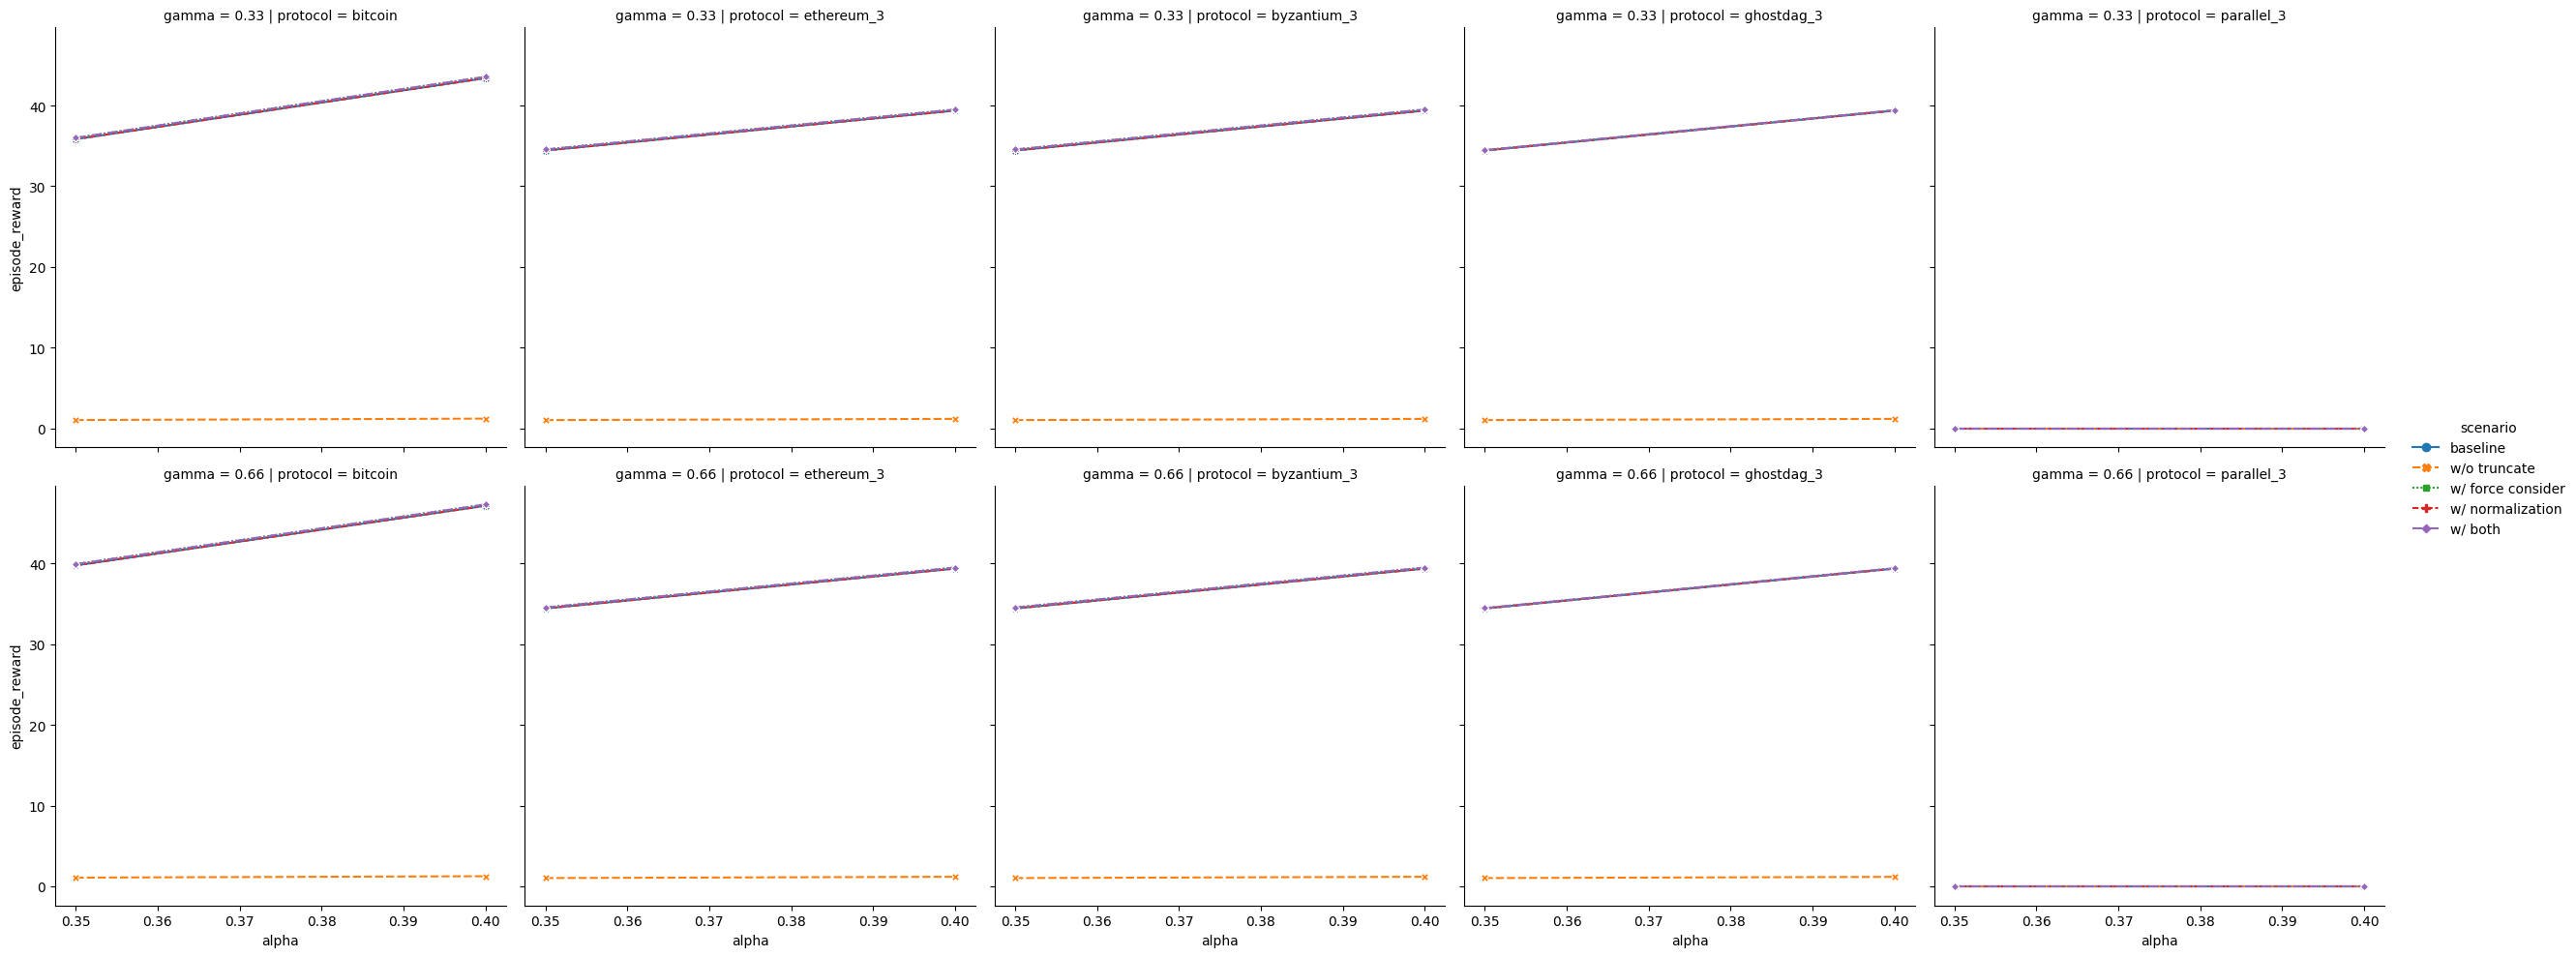

In [5]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_reward",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

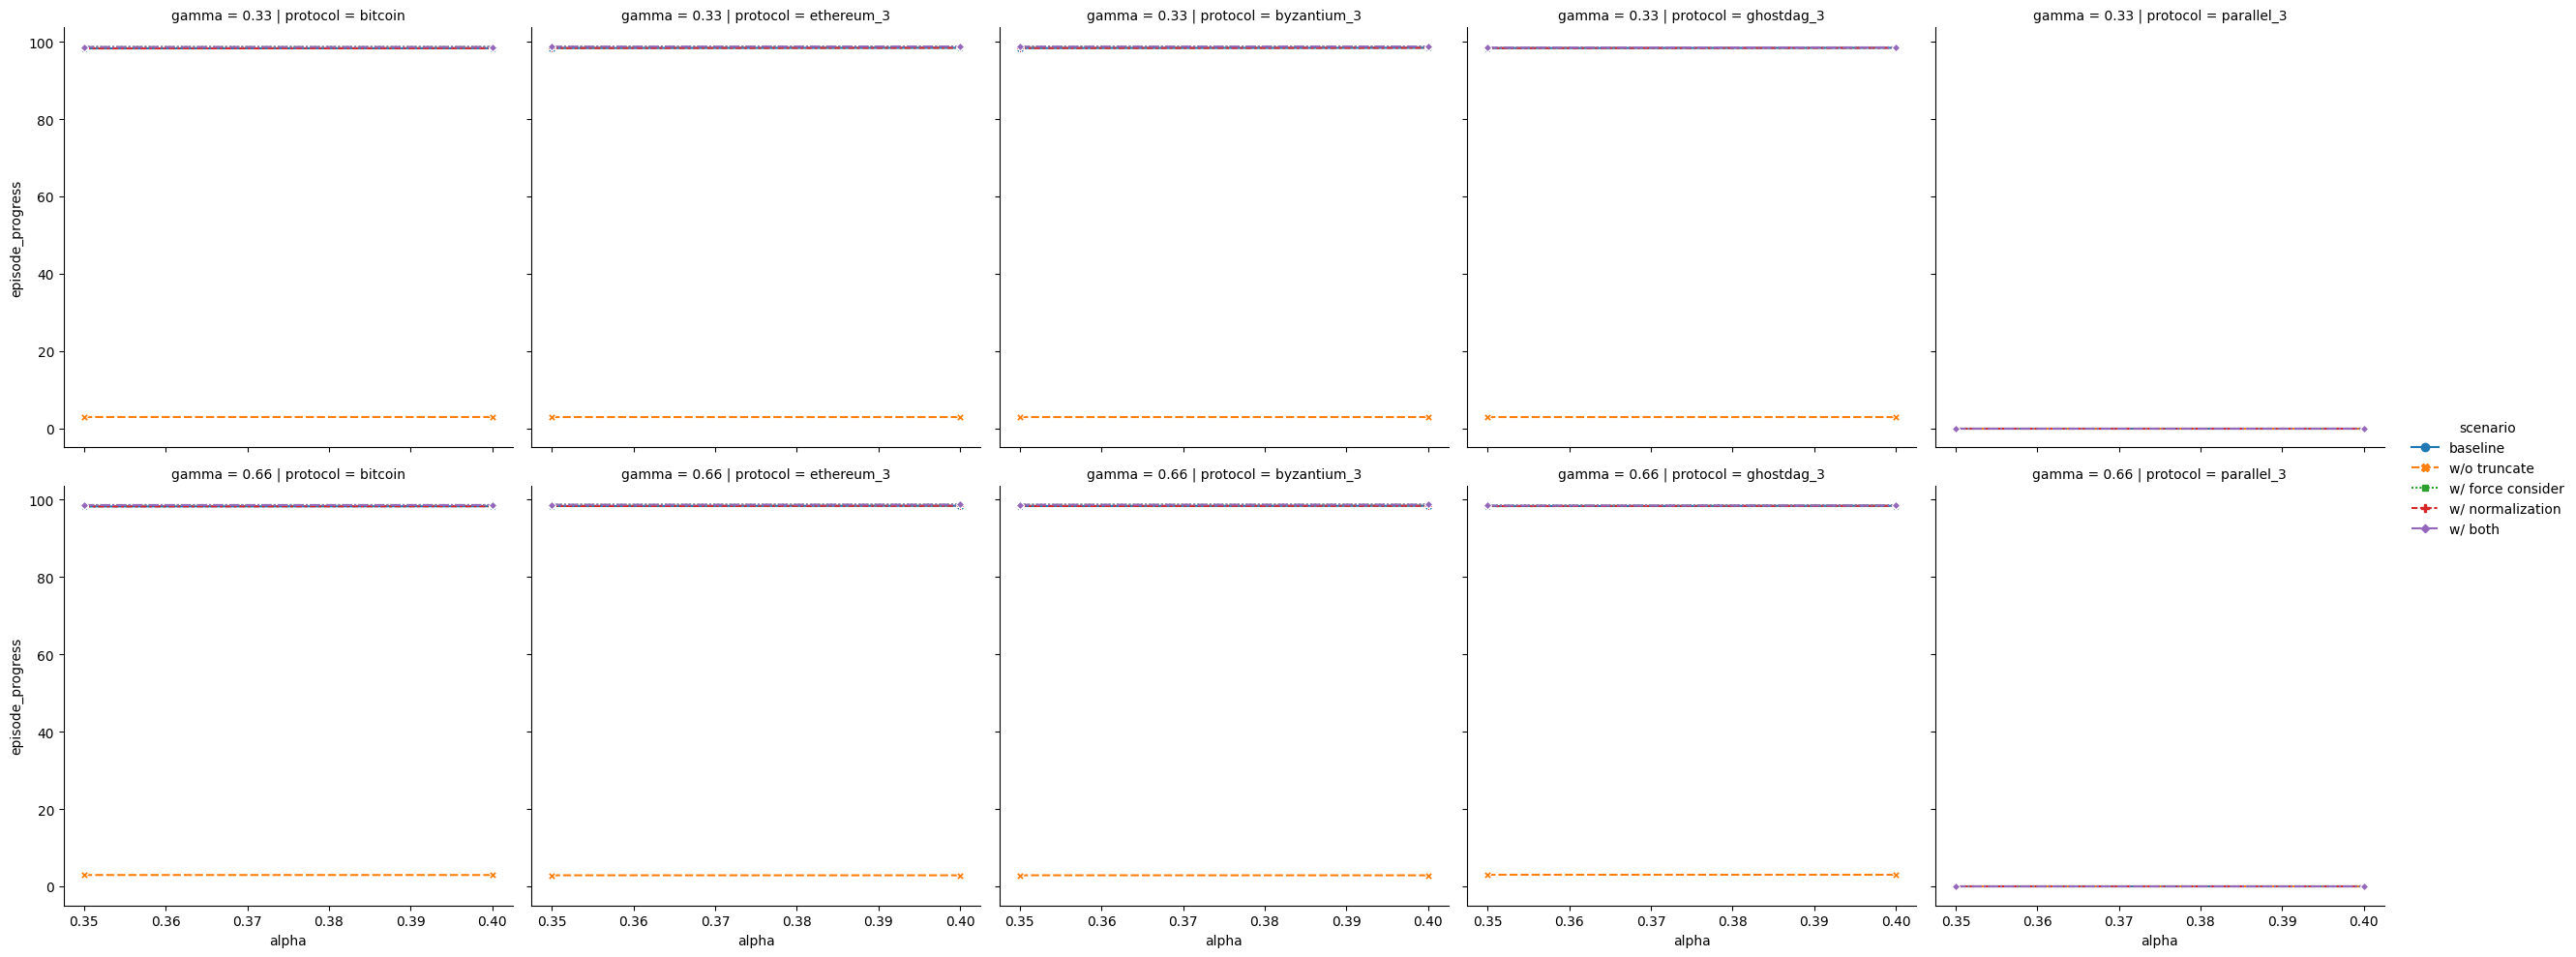

In [6]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_progress",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

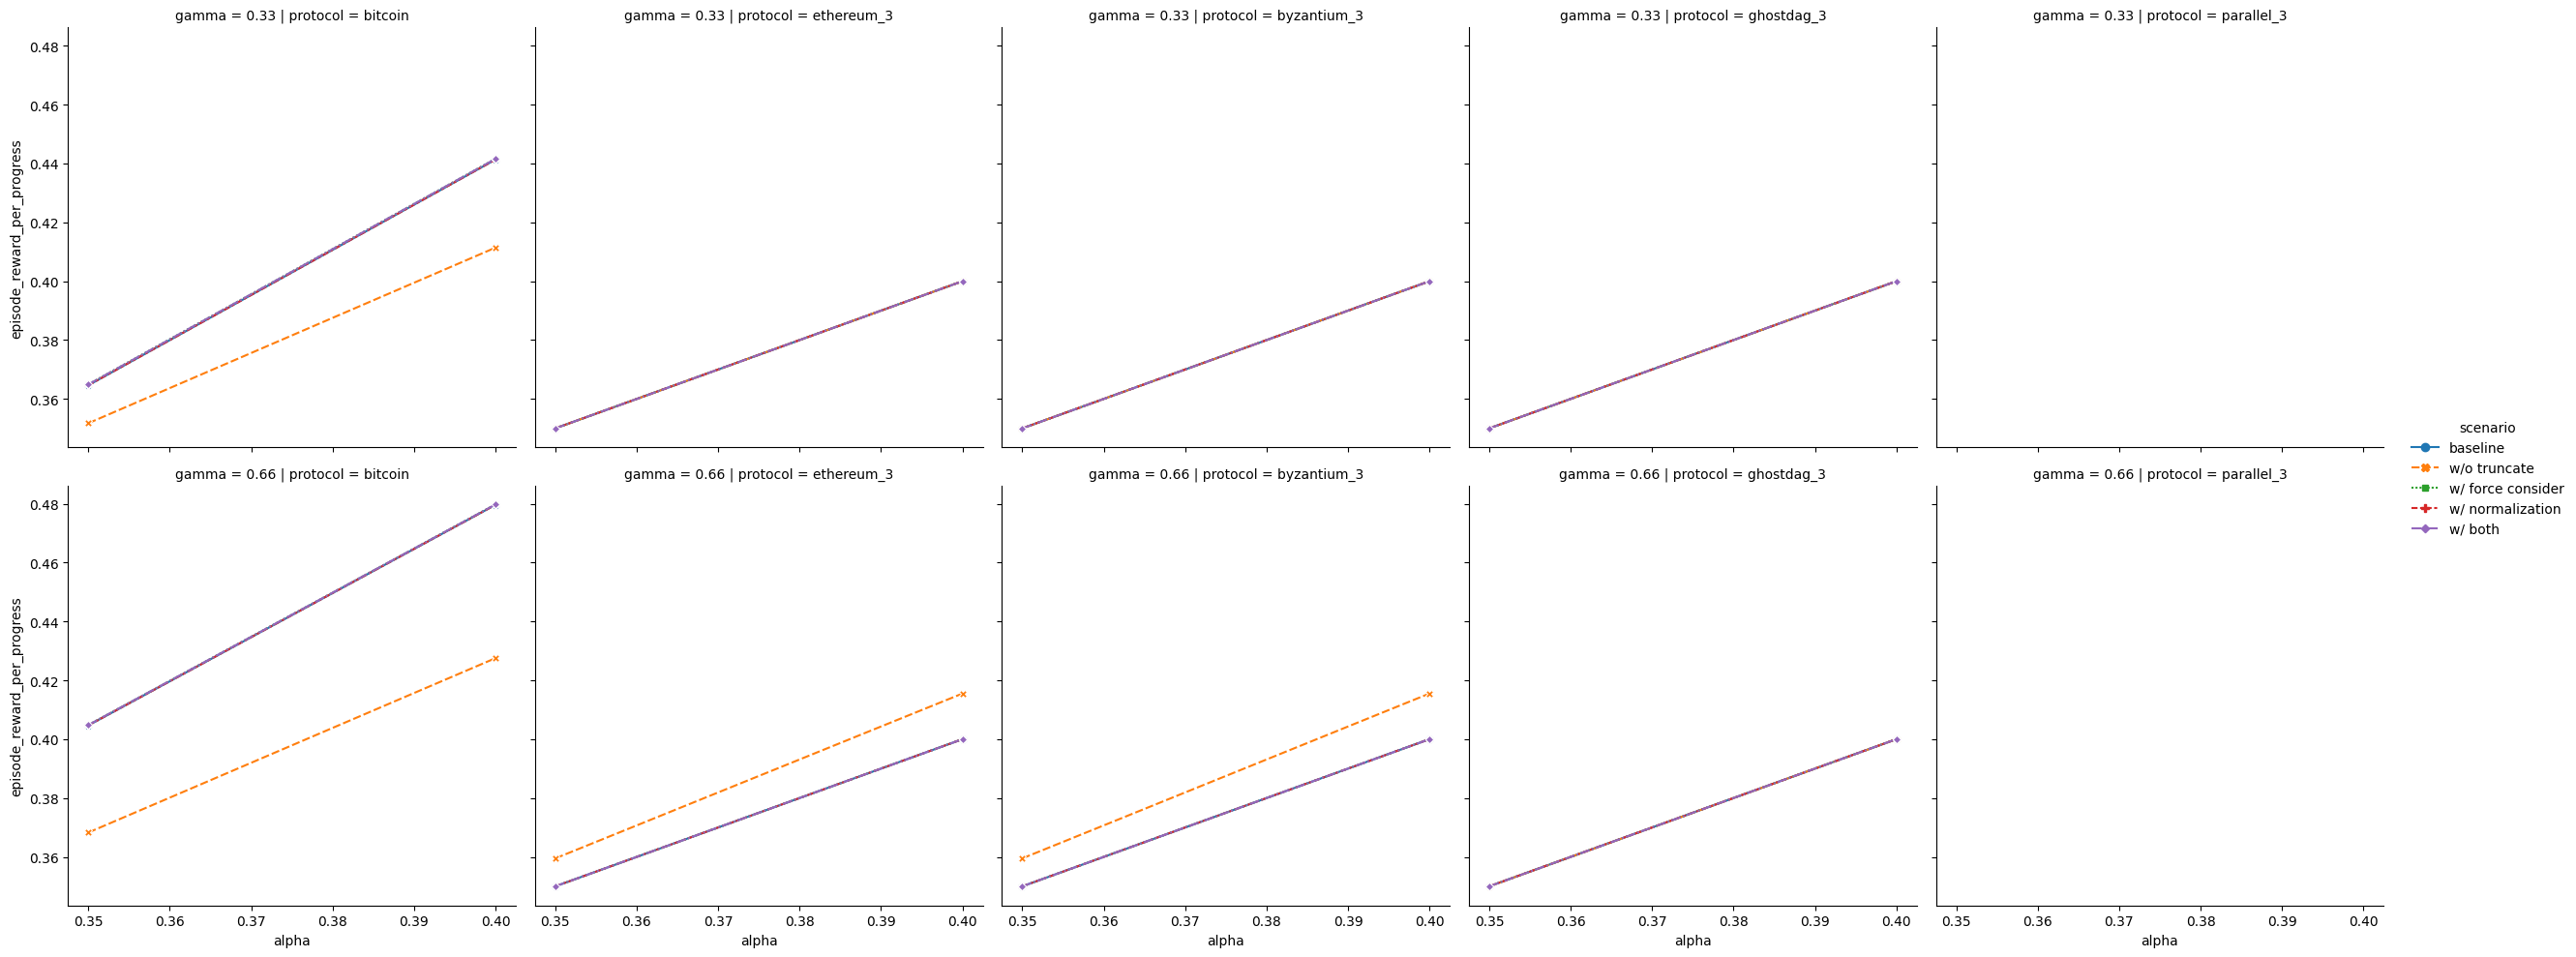

In [7]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_reward_per_progress",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

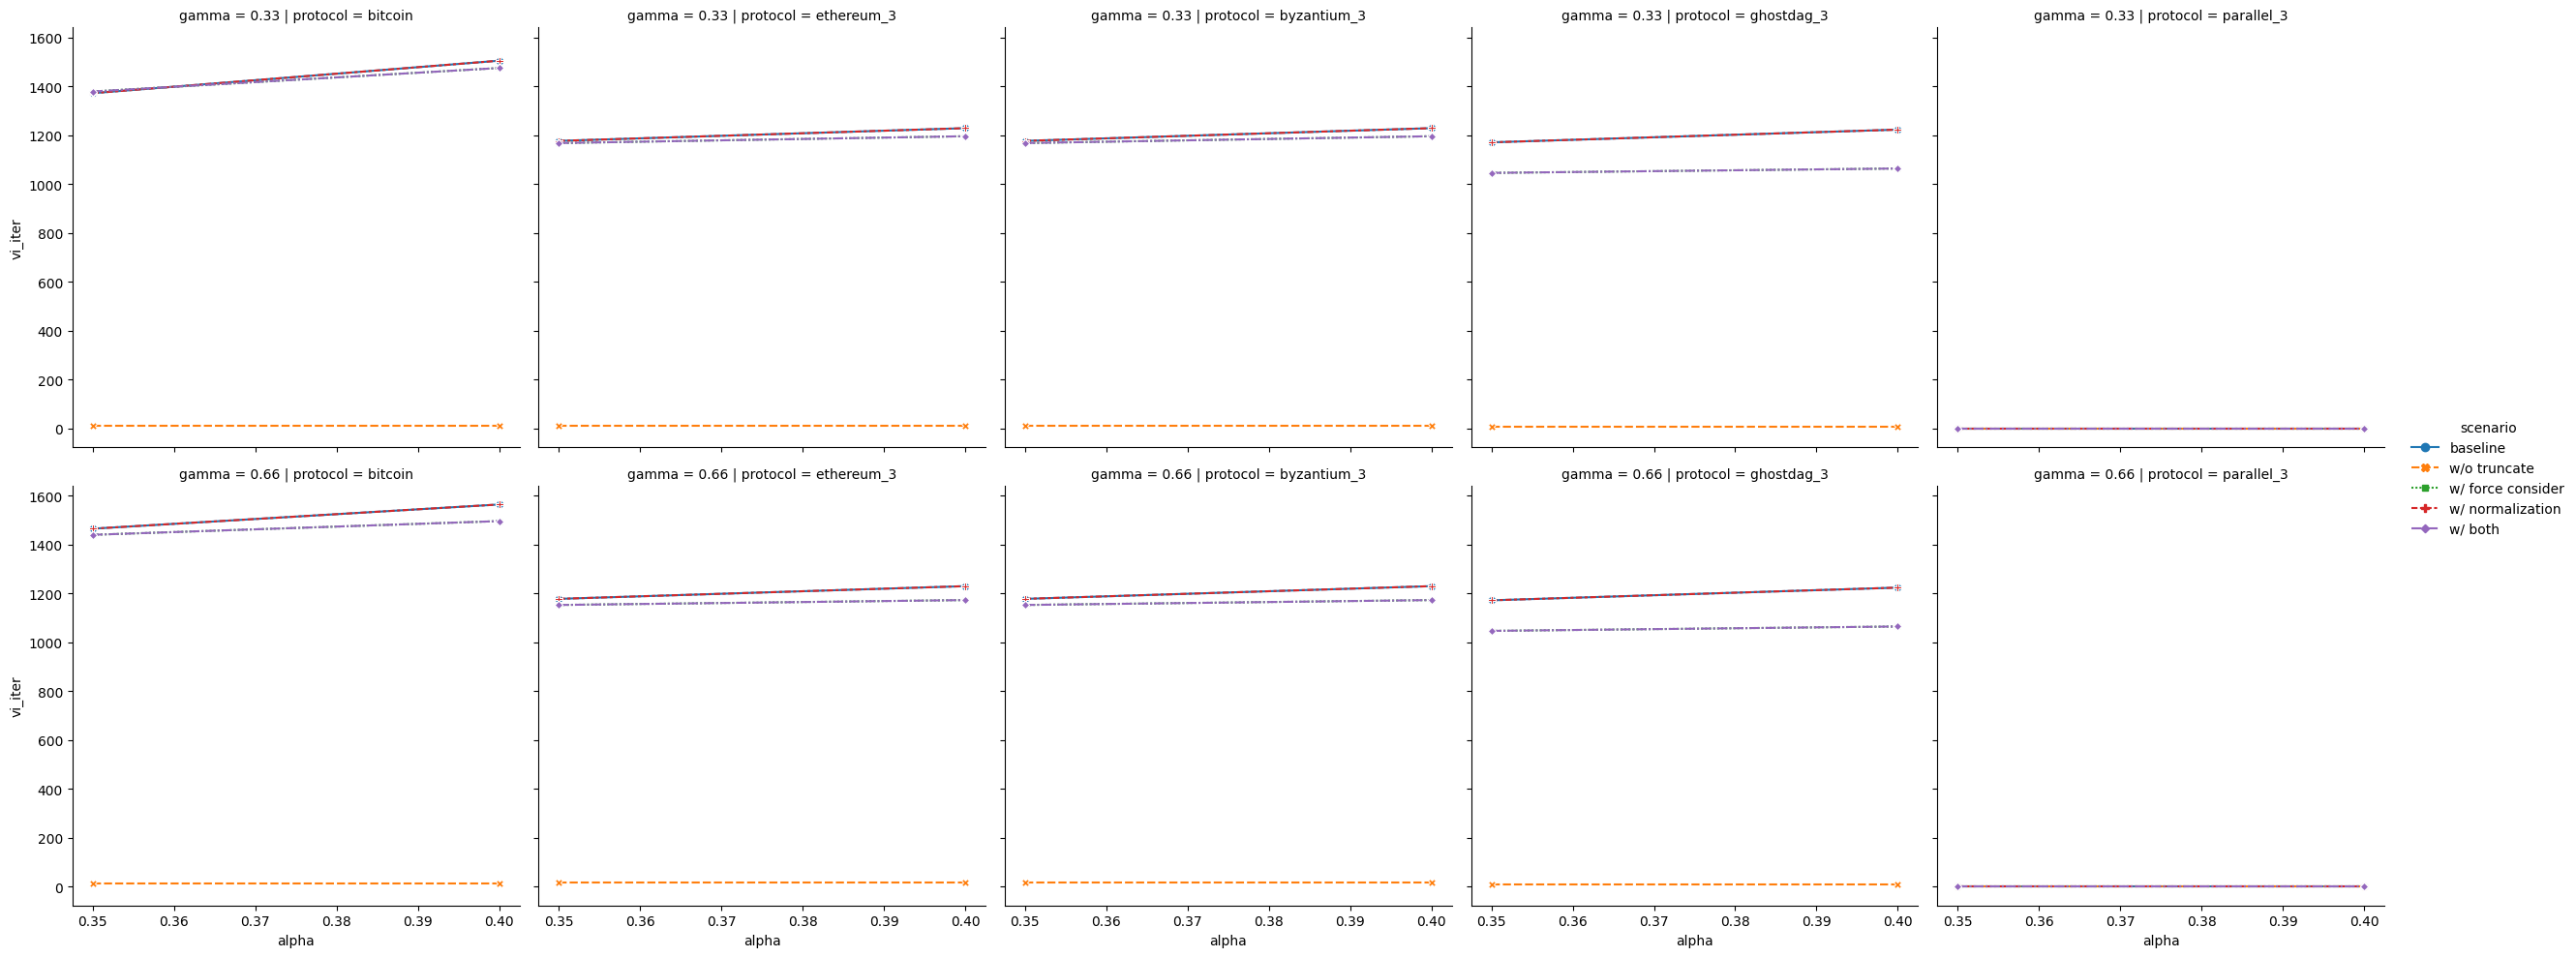

In [8]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="vi_iter",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)